# Extract phases
Created 02/06/2024

Objectives:
* Extract the fermionic and proj rep group cohomologies from the solutions calculated [here](sweep_and_find_solutions.ipynb)

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [136]:
from itertools import chain, groupby, combinations
import re

from collections import Counter, namedtuple, defaultdict

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
from jax import numpy as jnp
import pandas as pd

import matplotlib.pyplot as plt

import scipy

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

## Wavefunctions

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [10]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

In [12]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_non_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

## Boundary operator solutions

In [13]:
SOL_DIR = r"solutions/"

In [14]:
file_name_pattern = re.compile(r'^(?:non_)?triv_\d\.\d+_\d_\d_\d+\.pickle$')

In [15]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        print(file_name)
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    if file_name[0] == 'n':
        proj_rep=1
        b, bs, fs, i = file_name.split('_')[2:]
    elif file_name[0] == 't':
        proj_rep=0
        b, bs, fs, i = file_name.split('_')[1:]
    else:
        return None

    b = float(b)
    bs = int(bs)
    fs = int(fs)
    i = int(i)
    
    return (proj_rep, b, bs, fs, i)

In [16]:
boundary_operator_solutions = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            out = pickle.load(f)
    
            boundary_operator_solutions[key] = out

.DS_Store


### Check values

In [17]:
scores = [float(v[0]._value) for v in boundary_operator_solutions.values()]

In [18]:
pd.Series(scores).describe()

count    573.000000
mean      14.665053
std       22.783958
min        0.001833
25%        0.065218
50%        1.537037
75%       45.585068
max      216.741516
dtype: float64

In [19]:
score_pairs = defaultdict(list)

for k, v in boundary_operator_solutions.items():
    score_pairs[k[:-1]].append((k[-1], float(v[0]._value)))

In [20]:
help(min)

Help on built-in function min in module builtins:

min(...)
    min(iterable, *[, default=obj, key=func]) -> value
    min(arg1, arg2, *args, *[, key=func]) -> value
    
    With a single iterable argument, return its smallest item. The
    default keyword-only argument specifies an object to return if
    the provided iterable is empty.
    With two or more arguments, return the smallest argument.



In [21]:
best_score_pairs = {
    k: min(v, key=lambda x: x[1]) for k, v in score_pairs.items()
}

In [22]:
best_scores = [v[1] for v in best_score_pairs.values()]

In [23]:
len(best_score_pairs)

252

In [24]:
pd.Series(best_scores).describe()

count    252.000000
mean       1.737905
std        8.759257
min        0.001833
25%        0.018629
50%        0.053990
75%        0.203661
max       50.003654
dtype: float64

In [25]:
[k for k, v in best_score_pairs.items() if v[1]>1]

[(0, 0.5, 3, 1),
 (0, 0.5, 3, 0),
 (1, 0.5, 1, 1),
 (1, 0.5, 1, 0),
 (1, 0.5, 3, 0),
 (1, 0.5, 3, 1),
 (0, 0.5, 1, 0),
 (0, 0.5, 1, 1),
 (1, 0.5, 2, 0),
 (1, 0.5, 2, 1)]

In [26]:
best_score_pairs[(0, 0, 1, 0)]

(1, 0.017019841820001602)

In [27]:
best_boundary_operators = {
    k: boundary_operator_solutions[(*k, v[0])]
    for k, v in best_score_pairs.items()
    if k[1] != 0.5
}

In [28]:
len(best_boundary_operators)

240

# Definitions

In [29]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [30]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [31]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [32]:
fermionic_np_symmetries = [np_I, np_JW]

In [33]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [55]:
def generate_rdm_from_tenpy_psi(mps_psi, symmetry_site_pairs,
    leftmost_symmetry_site, num_symmetry_sites, num_boundary_sites):
    
    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())
    
    q1 = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )
    
    problem_rdm = generate_problem_rdm(
        q1,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    return problem_rdm

## Optimisation functions

In [35]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo_pair.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo_pair.tag_map['right_mpo']))
    )

    return (ml, mr)

In [36]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=0):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [37]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [38]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [39]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [40]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [41]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

## Extract SPT phase functions

In [42]:
def get_right_fp_overlap(rdm, mpo_l, mpo_r, leftmost_symmetry_site,
                     num_symmetry_sites, num_boundary_sites):

    tn = rdm.copy(deep=True)

    fermionic_site_indices = [
        i
        for i in range(
            leftmost_symmetry_site+num_symmetry_sites,
            leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
        )
        if i % 2 == 1
    ]

    top_fermionic_tensors = [
        (f'k{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'k{i}'])))
        for i in fermionic_site_indices
    ]

    bottom_fermionic_tensors = [
        (f'b{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'b{i}'])))
        for i in fermionic_site_indices
    ]

    for ind, t in top_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            inplace=True
        )

    for ind, t in bottom_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            transposed=True,
            inplace=True
        )

    out = (tn & mpo_l & mpo_r) ^ ...

    return out

In [43]:
def get_left_fp_overlap(rdm, mpo_l, mpo_r, leftmost_symmetry_site,
                     num_symmetry_sites, num_boundary_sites):

    tn = rdm.copy(deep=True)

    fermionic_site_indices = [
        i
        for i in range(
            leftmost_symmetry_site-num_boundary_sites,
            leftmost_symmetry_site
        )
        if i % 2 == 1
    ]

    top_fermionic_tensors = [
        (f'k{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'k{i}'])))
        for i in fermionic_site_indices
    ]

    bottom_fermionic_tensors = [
        (f'b{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'b{i}'])))
        for i in fermionic_site_indices
    ]

    for ind, t in top_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            inplace=True
        )

    for ind, t in bottom_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            transposed=True,
            inplace=True
        )

    out = (tn & mpo_l & mpo_r) ^ ...

    return out

In [50]:
def get_fp_charges(rdm, ml, mr, left_most_symmetry_site, num_symmetry_sites,
               num_boundary_sites):
    base_overlap = (rdm & ml & mr) ^ ...

    right_fp_overlap = get_right_fp_overlap(
        rdm,
        ml,
        mr,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    left_fp_overlap = get_left_fp_overlap(
        rdm,
        ml,
        mr,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    right_fp_charge = right_fp_overlap/base_overlap
    left_fp_charge = left_fp_overlap/base_overlap

    return (left_fp_charge, right_fp_charge, base_overlap)

# Extract SPT phase
## Fermionic group cohomology

In [51]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

total_physical_dim = 2**9

In [56]:
fp_charges = dict()

for k, ops in best_boundary_operators.items():
    ml, mr = split_mpo_pair(ops[1])

    if k[0] == 0:
        tenpy_psi = loaded_data_triv_proj_rep[k[1]]
    elif k[0] == 1:
        tenpy_psi = loaded_data_non_triv_proj_rep[k[1]]

    bs = bosonic_np_symmetries[k[2]]
    fs = fermionic_np_symmetries[k[3]]

    symmetry_site_pairs = (
        [(i, bs) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
        + [(i, fs) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
    )

    rdm = generate_rdm_from_tenpy_psi(
        tenpy_psi,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    out = get_fp_charges(
        rdm,
        ml,
        mr,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    fp_charges[k] = out

In [57]:
X = np.array(list(fp_charges.values()))

In [58]:
Counter(np.real(np.round(X[:, 1], 2)))

Counter({1.0: 120, -1.0: 120})

In [59]:
Counter(np.real(np.round(X[:, 0], 2)))

Counter({1.0: 120, -1.0: 120})

In [62]:
pd.Series(np.abs(X[:, 2])).describe()

count    240.000000
mean       0.972830
std        0.025664
min        0.885239
25%        0.960699
50%        0.982164
75%        0.991530
max        1.002534
dtype: float64

In [65]:
np.all(np.real(np.round(X[:, 1], 2)==np.real(np.round(X[:, 0], 2))))

True

In [71]:
single_fp_charges = {k: np.real(np.round(v[0], 2)) for k, v in fp_charges.items()}

In [86]:
g = groupby(single_fp_charges.items(), key=lambda x: x[0][:-1])
single_fp_charges_deduplicated = dict()

for k, v in g:
    values = [v1[1] for v1 in v]
    assert len(Counter(values)) == 1
    single_fp_charges_deduplicated[k] = values[0]

In [88]:
single_fp_charges_deduplicated

{(0, 0.9, 3): 1.0,
 (1, 0.35, 2): -1.0,
 (0, 0.45, 1): -1.0,
 (1, 0.25, 1): 1.0,
 (1, 0.4, 3): -1.0,
 (1, 0.05, 2): -1.0,
 (0, 0.45, 3): -1.0,
 (1, 0.15, 1): 1.0,
 (1, 0.3, 3): -1.0,
 (1, 0.35, 3): -1.0,
 (1, 0.65, 1): -1.0,
 (1, 0.75, 2): 1.0,
 (1, 0.4, 2): -1.0,
 (1, 0.55, 1): -1.0,
 (1, 0.45, 2): -1.0,
 (1, 0.3, 2): -1.0,
 (0, 0.7, 2): 1.0,
 (0, 0.0, 2): 1.0,
 (0, 0.25, 3): -1.0,
 (1, 0.45, 1): 1.0,
 (1, 0.1, 3): -1.0,
 (1, 0.55, 2): 1.0,
 (1, 0.4, 1): 1.0,
 (0, 0.65, 3): 1.0,
 (1, 0.25, 2): -1.0,
 (0, 0.2, 1): -1.0,
 (1, 0.2, 3): -1.0,
 (1, 0.35, 1): 1.0,
 (1, 0.8, 1): -1.0,
 (0, 0.85, 1): 1.0,
 (0, 0.15, 3): -1.0,
 (0, 0.95, 2): 1.0,
 (1, 0.2, 2): -1.0,
 (1, 0.1, 2): -1.0,
 (0, 1.0, 2): 1.0,
 (0, 0.8, 3): 1.0,
 (1, 0.15, 2): -1.0,
 (0, 0.55, 3): 1.0,
 (1, 0.0, 1): 1.0,
 (1, 0.45, 3): -1.0,
 (1, 0.85, 3): -1.0,
 (0, 0.4, 1): -1.0,
 (0, 0.3, 1): -1.0,
 (1, 0.9, 1): -1.0,
 (0, 0.1, 2): 1.0,
 (0, 0.6, 2): 1.0,
 (1, 0.05, 3): -1.0,
 (1, 0.0, 3): -1.0,
 (1, 0.65, 3): -1.0,
 (1, 0.6, 2):

Pull out correct cases.

In [89]:
signs_to_01 = {1.0: 0, -1.0: 1}

In [93]:
correct_boundary_operators = {
    k: best_boundary_operators[(*k, signs_to_01[v])][1]
    for k, v in single_fp_charges_deduplicated.items()
}

In [94]:
len(correct_boundary_operators)

120

In [95]:
correct_boundary_operators

{(0, 0.9, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.35, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (0, 0.45, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.25, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.4, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.05, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (0, 0.45, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.15, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.3, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.35, 3): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.65, 1): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.75, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.4, 2): TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6),
 (1, 0.55, 1): TensorNetwork1D(tensors=12, indices=34, 

## Proj rep group cohomology


### Group data definitions

In [137]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [138]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [139]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [140]:
e, a, b, c = symmetry_labels

In [141]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

### Evaluate

In [142]:
def tensor_network_to_mpo(tn):
    mpo = qtn.MatrixProductOperator(
        [t.data for t in ml.tensors],
        sites=sites
    )

    return mpo

In [149]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    t = (
        rho
        ._apply_mpo(qu.dag(u_g), compress=False, contract=False)
        ._apply_mpo(qu.dag(u_h), compress=False, contract=False)
        ._apply_mpo(u_gh, compress=False, contract=False)
    )

    out = t.trace()

    return out/(np.abs(out))

In [150]:
def get_quimb_mps_from_tenpy_mps(tenpy_mps):
    psi_arrays = list()
    psi_arrays.append(tenpy_mps.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, tenpy_mps.L-1):
        psi_arrays.append(tenpy_mps.get_B(i).to_ndarray())
    psi_arrays.append(tenpy_mps.get_B(tenpy_mps.L-1)[..., 0].to_ndarray())
    
    quimb_mps = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    return quimb_mps

In [ ]:
def get_proj_rep_phases(tenpy_mps, unitaries):
    quimb_mps = get_quimb_mps_from_tenpy_mps(tenpy_mps)

    
    out = list()

    for a, b, c in group_products:
        get_proj_rep_phase(
            rho,
            u_g,
            u_h,
            u_gh
        )

In [97]:
ml, mr = split_mpo_pair(correct_boundary_operators[(0, 0, 1)])

In [98]:
ml

TensorNetwork(tensors=6, indices=17)

In [99]:
mr

TensorNetwork(tensors=6, indices=17)

In [114]:
mpo

MatrixProductOperator(tensors=6, indices=17, L=60, max_bond=6)

In [115]:
mps_psi = loaded_data_triv_proj_rep[0]

In [116]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

In [127]:
rho = q1.partial_trace_to_mpo(sites, rescale_sites=False)

In [128]:
rho

MatrixProductOperator(tensors=6, indices=17, L=200, max_bond=4)

In [129]:
mpo

MatrixProductOperator(tensors=6, indices=17, L=60, max_bond=6)

In [134]:
t = rho._apply_mpo(mpo, compress=False, contract=False)

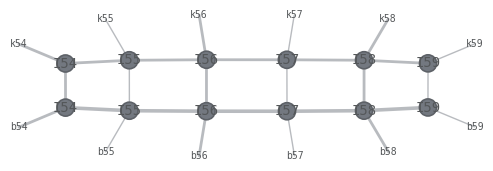

In [135]:
t.draw()

In [103]:
sites = [
    int(s[1:]) for s in ml.tag_map
    if s[0]=='I'
]

In [104]:
sites

[54, 55, 56, 57, 58, 59]